# CNN for Trading - Part 2: From Time-Series Features to Clustered Images

To exploit the grid-like structure of time-series data, we can use CNN architectures for univariate and multivariate time series. In the latter case, we consider different time series as channels, similar to the different color signals.

An alternative approach converts a time series of alpha factors into a two-dimensional format to leverage the ability of CNNs to detect local patterns. [Sezer and Ozbayoglu (2018)](https://www.researchgate.net/publication/324802031_Algorithmic_Financial_Trading_with_Deep_Convolutional_Neural_Networks_Time_Series_to_Image_Conversion_Approach) propose CNN-TA, which computes 15 technical indicators for different intervals and uses hierarchical clustering (see Chapter 13, Data-Driven Risk Factors and Asset Allocation with Unsupervised Learning) to locate indicators that behave similarly close to each other in a two-dimensional grid.

The authors train a CNN similar to the CIFAR-10 example we used earlier to predict whether to buy, hold, or sell an asset on a given day. They compare the CNN performance to "buy-and-hold" and other models and find that it outperforms all alternatives using daily price series for Dow 30 stocks and the nine most-traded ETFs over the 2007-2017 time period.

The section on *CNN for Trading* consists of three notebooks that experiment with this approach using daily US equity price data. They demonstrate 
1. How to compute relevant financial features
2. How to convert a similar set of indicators into image format and cluster them by similarity
3. How to train a CNN to predict daily returns and evaluate a simple long-short strategy based on the resulting signals.

## Selecting and Clustering Features

The next steps that we will tackle in this notebook are 
1. Select the 15 most relevant features from the 20 candidates to fill the 15×15 input grid.
2. Apply hierarchical clustering to identify features that behave similarly and order the columns and the rows of the grid accordingly.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
from pathlib import Path
import pandas as pd
from tqdm import tqdm

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
MONTH = 21
YEAR = 12 * MONTH

In [4]:
START = '2001-01-01'
END = '2017-12-31'

In [5]:
sns.set_style('white')
idx = pd.IndexSlice

In [6]:
results_path = Path('results', 'cnn_for_trading')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Load Model Data

In [7]:
with pd.HDFStore('data.h5') as store:
    features = store.get('features')
    targets = store.get('targets')

In [8]:
features.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2372451 entries, ('A', Timestamp('2001-01-02 00:00:00')) to ('UAL', Timestamp('2017-12-29 00:00:00'))
Columns: 300 entries, 06_RSI to 85_CMA
dtypes: float64(300)
memory usage: 5.3+ GB


In [9]:
targets.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2372451 entries, ('A', Timestamp('2001-01-02 00:00:00')) to ('UAL', Timestamp('2017-12-29 00:00:00'))
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   r01_fwd     float64
 1   r01dec_fwd  float64
 2   r05_fwd     float64
 3   r05dec_fwd  float64
dtypes: float64(4)
memory usage: 81.6+ MB


## Select Features using Mutual Information

To this end, we estimate the mutual information for each indicator and the 15 intervals with respect to our target, the one-day forward returns. As discussed in Chapter 4, Financial Feature Engineering – How to Research Alpha Factors, scikit-learn provides the `mutual_info_regression()` function that makes this straightforward, albeit time-consuming and memory-intensive. 

To accelerate the process, we randomly sample 100,000 observations:

In [10]:
mi = {}
for t in tqdm([1, 5]):
    target = f'r{t:02}_fwd'
    # sample a smaller number to speed up the computation
    df = features.join(targets[target]).dropna().sample(n=100000)
    X = df.drop(target, axis=1)
    y = df[target]
    mi[t] = pd.Series(mutual_info_regression(X=X, y=y),
                      index=X.columns).sort_values(ascending=False)

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [09:15<00:00, 277.95s/it]


In [11]:
mutual_info = pd.DataFrame(mi)
mutual_info.to_hdf('data.h5', 'mutual_info')

In [12]:
mutual_info = pd.read_hdf('data.h5', 'mutual_info')

In [13]:
mi_by_indicator = (mutual_info.groupby(mutual_info.
                                       index.to_series()
                                       .str.split('_').str[-1])
                   .mean()
                   .rank(ascending=False)
                   .sort_values(by=1))

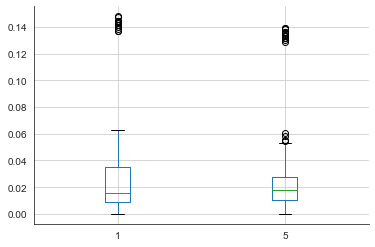

In [14]:
mutual_info.boxplot()
sns.despine();

The below figure shows the mutual information, averaged across the 15 intervals for each indicator. NATR, PPO, and Bollinger Bands are most important from this metric's perspective:

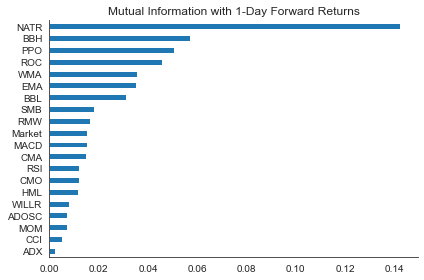

In [15]:
(mutual_info.groupby(mutual_info.index.to_series().str.split('_').str[-1])[1]
 .mean()
 .sort_values().plot.barh(title='Mutual Information with 1-Day Forward Returns'))
sns.despine()
plt.tight_layout()
plt.savefig(results_path / 'mutual_info_cnn_features', dpi=300)

In [16]:
best_features = mi_by_indicator.head(15).index

In [17]:
size = len(best_features)

## Hierarchical Feature Clustering

In [18]:
features = pd.concat([features.filter(like=f'_{f}') for f in best_features], axis=1)

In [19]:
new_cols = {}
for feature in best_features:
    fnames = sorted(features.filter(like=f'_{feature}').columns.tolist())
    renamed = [f'{i:02}_{feature}' for i in range(1, len(fnames)+ 1)]
    new_cols.update(dict(zip(fnames, renamed)))
features = features.rename(columns=new_cols).sort_index(1)

In [20]:
features.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2372451 entries, ('A', Timestamp('2001-01-02 00:00:00')) to ('UAL', Timestamp('2017-12-29 00:00:00'))
Columns: 225 entries, 01_BBH to 15_WMA
dtypes: float64(225)
memory usage: 4.0+ GB


## Hierarchical Clustering

As discussed in the first section of this chapter, CNNs rely on the locality of relevant patterns that is typically found in images where nearby pixels are closely related and changes from one pixel to the next are often gradual.

To organize our indicators in a similar fashion, we will follow Sezer and Ozbayoglu's approach of applying hierarchical clustering. The goal is to identify features that behave similarly and order the columns and the rows of the grid accordingly.

We can build on SciPy's `pairwise_distance()`, `linkage()`, and `dendrogram()` functions that we introduced in *Chapter 13, Data-Driven Risk Factors and Asset Allocation with Unsupervised Learning* alongside other forms of clustering. 

We create a helper function that standardizes the input column-wise to avoid distorting distances among features due to differences in scale, and use the Ward criterion that merges clusters to minimize variance. The function
returns the order of the leaf nodes in the dendrogram that in turn displays the successive formation of larger clusters:

In [21]:
def cluster_features(data, labels, ax, title):
    data = StandardScaler().fit_transform(data)
    pairwise_distance = pdist(data)
    Z = linkage(data, 'ward')
    c, coph_dists = cophenet(Z, pairwise_distance)
    dend = dendrogram(Z,
                      labels=labels,
                      orientation='top',
                      leaf_rotation=0.,
                      leaf_font_size=8.,
                      ax=ax)
    ax.set_title(title)
    return dend['ivl']

To obtain the optimized order of technical indicators in the columns and the different intervals in the rows, we use NumPy's `.reshape()` method to ensure that the dimension we would like to cluster appears in the columns of the two-dimensional array we pass to `cluster_features()`.

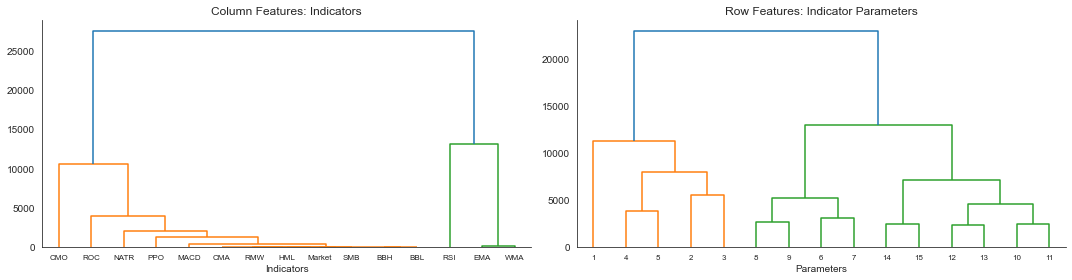

In [22]:
fig, axes = plt.subplots(figsize=(15, 4), ncols=2)

labels = sorted(best_features)
title = 'Column Features: Indicators'
col_order = cluster_features(features.dropna().values.reshape(-1, 15).T,
                             labels,
                             axes[0],
                             title)

labels = list(range(1, 16))
title = 'Row Features: Indicator Parameters'
row_order = cluster_features(
    features.dropna().values.reshape(-1, 15, 15).transpose((0, 2, 1)).reshape(-1, 15).T,
    labels, axes[1], title)
axes[0].set_xlabel('Indicators')
axes[1].set_xlabel('Parameters')
sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'cnn_clustering', dpi=300)

We reorder the features accordingly and store the result as inputs for the CNN that we will create in the next step.


In [23]:
feature_order = [f'{i:02}_{j}' for i in row_order for j in col_order]

In [24]:
features = features.loc[:, feature_order]

In [25]:
features = features.apply(pd.to_numeric, downcast='float')

In [26]:
features.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2372451 entries, ('A', Timestamp('2001-01-02 00:00:00')) to ('UAL', Timestamp('2017-12-29 00:00:00'))
Columns: 225 entries, 01_CMO to 11_WMA
dtypes: float32(225)
memory usage: 2.0+ GB


In [27]:
features.to_hdf('data.h5', 'img_data')